# Imports

In [1]:
from library.dataPreprocessLib import *
from library.resultsLib import *
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import os

# Data Preprocessing

## Feature Selection and Loading Data

In [83]:
#name = "prantika_bus_stand"
#name = "junction_mall"
#name = "54ft_road"
#name = "dvc_more"
name = "station"

In [84]:
parent_dir = r"../data/54ft/"
train_df_name = r"54ft_train.csv"
test_df_name = f"{name}_test_split.csv"

In [85]:
poi_column = 'Is_Congestion'
output_result_filename = f"{poi_column}_test_result_{name}_zone.csv"

In [86]:
#feature # binding
F=\
    {1:'stay_duration', #f1
     2:'mfcc0',3:'mfcc1',4:'mfcc2',5:'mfcc3',6:'mfcc4', #f2,f3,f4,f5,f6
     7:'wifi_count', 8:'edge_wifi_count', #f7,f8
     9:'RSI', #f9
     10:'human_made', 11:'natural_land',12:'road_exist_percent',13:'highly_populated_poi_exist'#f10,f11,f12,f13
    }



feature_names=[F[e] for e in [2,11,10,9,12,8,6,1]]

### Training Data

In [87]:
train_csv_df = pd.read_csv(os.path.join(parent_dir, train_df_name))
train_df = train_csv_df[feature_names+[poi_column]]
train_df.head()

,mfcc0,natural_land,human_made,RSI,road_exist_percent,edge_wifi_count,mfcc4,stay_duration,Is_Congestion
0,39.288479,0.636805,0.111232,0.000000,0.251963,0.000000,7.541212,6,0
1,42.699326,0.666587,0.124869,2.715045,0.208544,0.015468,8.094163,10,0
2,70.480301,0.743668,0.100360,2.422751,0.155972,0.027800,6.575349,130,0
3,76.429749,0.730013,0.100911,3.040420,0.169076,0.000000,7.560440,13,0
4,71.429588,0.487688,0.117394,1.780860,0.183064,0.002818,8.189456,9,0


### Testing Data

In [88]:
test_csv_df = pd.read_csv(os.path.join(parent_dir, test_df_name))
test_df = test_csv_df[feature_names+[poi_column]]
test_df.head()

,mfcc0,natural_land,human_made,RSI,road_exist_percent,edge_wifi_count,mfcc4,stay_duration,Is_Congestion
0,46.814274,0.692291,0.122769,0.000000,0.182053,0.000000,-4.031920,105,1
1,85.492668,0.766882,0.107162,1.289747,0.125955,0.024291,-3.588506,12,1
2,80.570160,0.697338,0.160116,32.959722,0.142546,0.000000,-6.036549,95,1
3,59.378181,0.700820,0.112501,4.292388,0.175124,0.012752,-4.283316,102,1
4,44.661961,0.730924,0.124594,1.737973,0.144481,0.007056,3.639375,4,1


### Seperating target column and input columns

In [89]:
X = train_df[feature_names].copy()
y = train_df[poi_column].copy()

## Using SMOTE

In [90]:
smote = SMOTE()

In [91]:
X_resampled, y_resampled = smote.fit_sample(X, y)
print(X.shape)
print(y.shape)
print(X_resampled.shape)
print(y_resampled.shape)

(2480, 8)
(2480,)
(4492, 8)
(4492,)


## Categorical data Transformation

### For train data

In [92]:
train_data = X_resampled.copy()
train_labels = y_resampled.copy()

### For test data

In [93]:
test_data = test_df[feature_names].values
test_labels = test_df[poi_column].values

# Training

In [94]:
model = RandomForestClassifier(n_estimators=20,max_depth=8)
model.fit(train_data, train_labels)
train_predictions = model.predict(train_data) # for training performance stat

# Testing

In [95]:
assert test_data.shape[1] == train_data.shape[1]
test_predictions = model.predict(test_data)

# Performance Stat

## Training Performance

In [96]:
get_performance_stats("train", train_labels, train_predictions)

For train: 
	Accuracy: 0.9102849510240427
	Precision: 0.911908327669572
	Recall: 0.9102849510240427
	F1 score: 0.9101964695925223
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      2246
           1       0.89      0.94      0.91      2246

    accuracy                           0.91      4492
   macro avg       0.91      0.91      0.91      4492
weighted avg       0.91      0.91      0.91      4492



## Testing Performance

In [97]:
get_performance_stats("test", test_labels, test_predictions)

For test: 
	Accuracy: 0.6944444444444444
	Precision: 0.8824307500778088
	Recall: 0.6944444444444444
	F1 score: 0.7677459075764159
              precision    recall  f1-score   support

           0       0.10      0.40      0.15         5
           1       0.94      0.72      0.81        67

    accuracy                           0.69        72
   macro avg       0.52      0.56      0.48        72
weighted avg       0.88      0.69      0.77        72



### Confusion Matrix

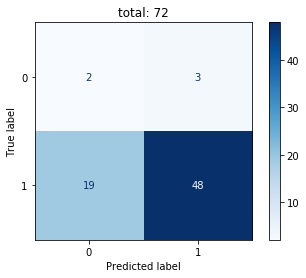

In [98]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
disp = plot_confusion_matrix(model, test_data, test_labels, cmap=plt.cm.Blues)
disp.ax_.set_title(f'total: {len(test_data)}')
plt.show()

### Check & Save Predicitons

In [99]:
result_df = form_result_df(test_csv_df, test_predictions, poi_column)
result_df.head()

,instance_date,instance_start_time,instance_end_time,Prediction Is_Congestion
0,09/14/2019,12:04:16,12:06:01,0
1,09/14/2019,12:06:36,12:06:47,0
2,09/14/2019,16:39:20,16:40:54,1
3,09/14/2019,16:45:03,16:46:45,1
4,09/14/2019,11:39:46,11:39:49,0


In [100]:
result_df.to_csv(os.path.join(parent_dir, output_result_filename), index=False)

In [101]:
test_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int64)

In [102]:
test_predictions

array([0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int64)